## Check where this runs
***

In [1]:
import sys
sys.path.append("..") # this is only to enable imports in cell below...(!)
from util.minor_funcs import Minors
m_funcs = Minors()
environment_running = m_funcs.check_environs()

# IMPORTS
***

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import os
import time
            # data sourcing:
import csv
            # databases:
import sqlite3
            # useful other
from collections import defaultdict
            # data toolkit:
import numpy as np
import pandas as pd
import dask.dataframe as dd
            # plotting
import matplotlib.pyplot as plt
%matplotlib inline  

if not environment_running == 'laptop':
    %pip install seaborn
    # no seaborn by default in AWS SageMaker.
    
import seaborn as sns

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
 # Visualizing Pipelines in HTML
from sklearn import set_config; set_config(display='diagram')

## Establish paths

In [60]:
from path_defs.path_definitions import ATP_paths
paths = ATP_paths()
atp_data_path = paths.get_atp_data_path()
read_data_path = paths.get_read_data_path()
cleaned_once_data_path = paths.get_cleaned_once_data_path()
matches_data_path_full = paths.get_matches_data_path_full()

# Show getting 50k rows works:

In [45]:
# this works to convert dates as reading in. good news
schema = {'start_date': 'datetime64[ns]', 'end_date': 'datetime64[ns]'}
matches_df_1st_50k = pd.read_csv(matches_data_path_full, nrows=50_000, index_col=None).astype(schema)

/tmp/ipykernel_39237/2131584680.py:3: DtypeWarning: Columns (8,10,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  matches_df_1st_50k = pd.read_csv(matches_data_path_full, nrows=50_000, index_col=None).astype(schema)


In [7]:
matches_df_1st_50k.dtypes.head()
# this confirms astype(schema) works, so date manipulation is available

start_date       datetime64[ns]
end_date         datetime64[ns]
location                 object
court_surface            object
prize_money             float64
dtype: object

In [8]:
matches_df_1st_50k.columns

Index(['start_date', 'end_date', 'location', 'court_surface', 'prize_money',
       'currency', 'year', 'player_id', 'player_name', 'opponent_id',
       'opponent_name', 'tournament', 'round', 'num_sets', 'sets_won',
       'games_won', 'games_against', 'tiebreaks_won', 'tiebreaks_total',
       'serve_rating', 'aces', 'double_faults', 'first_serve_made',
       'first_serve_attempted', 'first_serve_points_made',
       'first_serve_points_attempted', 'second_serve_points_made',
       'second_serve_points_attempted', 'break_points_saved',
       'break_points_against', 'service_games_won', 'return_rating',
       'first_serve_return_points_made', 'first_serve_return_points_attempted',
       'second_serve_return_points_made',
       'second_serve_return_points_attempted', 'break_points_made',
       'break_points_attempted', 'return_games_played', 'service_points_won',
       'service_points_attempted', 'return_points_won',
       'return_points_attempted', 'total_points_won', 'total

# Organise for broad categories of column

In [46]:
# keep a simple dict of columns, based on type
check_completeness = {'start_date': 0, 'end_date': 0, 'player_name': 0, 
                      'duration': 0
                      }
check_key_distinguishing_columns = {'doubles': 0, 'masters': 0, 'nation': 0
                                    , 'seed': 0, 'prize_money': 0
                                    }
check_numerical_columns = {'prize_money': 0,'sets_won': 0,'games_won': 0,  
                           'games_against': 0, 'tiebreaks_won': 0,  'tiebreaks_total': 0,
                      'serve_rating': 0, 'aces': 0, 
                      'double_faults': 0, 'first_serve_made': 0, 
                      'first_serve_attempted': 0, 'first_serve_points_made': 0,  
                      'first_serve_points_attempted': 0, 'second_serve_points_made': 0, 
                      'second_serve_points_attempted': 0, 'break_points_saved': 0, 
                      'break_points_against': 0, 'service_games_won': 0, 
                      'return_rating': 0, 'first_serve_return_points_made': 0, 
                      'first_serve_return_points_attempted': 0, 'second_serve_return_points_made': 0, 
                      'second_serve_return_points_attempted': 0, 'break_points_made': 0, 
                      'break_points_attempted': 0, 'return_games_played': 0, 
                      'service_points_won': 0, 'service_points_attempted': 0, 
                      'return_points_won': 0, 'return_points_attempted': 0, 
                      'total_points_won': 0, 'total_points': 0, 
                      'duration': 0, 
                      # distinguishing column:
                      'round_num': 0
                      }
check_mixed_columns = {'seed': 0, 'currency': 0, 'player_name': 0, 'opponent_name': 0, 'duration': 0
                       }
check_boolean_columns = {'player_victory': 0, 'retirement': 0, 'won_first_set': 0,
                         'doubles': 0, }

In [47]:
# queries 
single_date_query = {"start_date > 2010": 0}
single_year_query = {"year > 2010": 0}


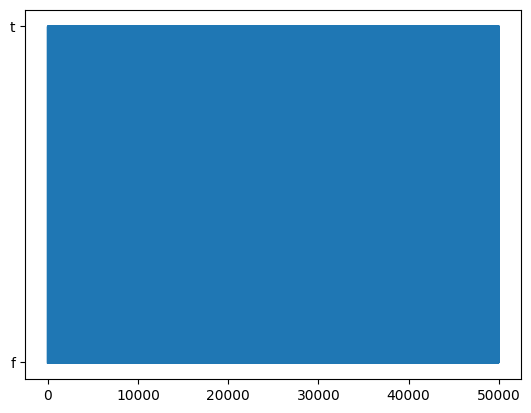

In [48]:
plt.plot(matches_df_1st_50k.player_victory);

# Sorting and cleaning through
Collection of drops, then pipeline construction

## Collection of Drops, Masks, Filters etc

In [49]:
matches_df_1st_50k.won_first_set.isna().sum()

699

In [50]:
matches_df_1st_50k.isnull().sum()

start_date                                  0
end_date                                 1033
location                                    0
court_surface                               0
prize_money                             34463
currency                                34463
year                                        0
player_id                                   0
player_name                             39702
opponent_id                                 0
opponent_name                           39702
tournament                                  0
round                                       0
num_sets                                    0
sets_won                                    0
games_won                                   0
games_against                               0
tiebreaks_won                               0
tiebreaks_total                             0
serve_rating                            39702
aces                                    39702
double_faults                     

In [51]:
matches_df_1st_50k.won_first_set.value_counts(dropna=False)

t      24655
f      24646
NaN      699
Name: won_first_set, dtype: int64

In [52]:
# Sorting won_first_set
matches_df_1st_50k = matches_df_1st_50k[matches_df_1st_50k["won_first_set"].isin(["t","f"])]
matches_df_1st_50k.won_first_set.value_counts(dropna=False)

t    24655
f    24646
Name: won_first_set, dtype: int64

In [53]:
# Sorting the 39k empty numerical rows
# Assuming that if we drop the serve_rating then we also drop the correct all other null rows:
matches_df_1st_50k = matches_df_1st_50k.dropna()

In [54]:
matches_df_1st_50k.isnull().sum()

start_date                              0
end_date                                0
location                                0
court_surface                           0
prize_money                             0
currency                                0
year                                    0
player_id                               0
player_name                             0
opponent_id                             0
opponent_name                           0
tournament                              0
round                                   0
num_sets                                0
sets_won                                0
games_won                               0
games_against                           0
tiebreaks_won                           0
tiebreaks_total                         0
serve_rating                            0
aces                                    0
double_faults                           0
first_serve_made                        0
first_serve_attempted             

In [55]:
matches_df_1st_50k

,start_date,end_date,location,court_surface,prize_money,currency,year,player_id,player_name,opponent_id,...,total_points,duration,player_victory,retirement,seed,won_first_set,doubles,masters,round_num,nation
4,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,alessandro-giannessi,A. Giannessi,harri-heliovaara,...,194.0,02:32:00,t,f,1,t,f,100,3,Slovakia
5,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,alessandro-giannessi,A. Giannessi,nils-langer,...,106.0,01:08:00,t,f,1,t,f,100,4,Slovakia
6,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,alessandro-giannessi,A. Giannessi,simon-greul,...,89.0,01:18:00,f,f,1,f,f,100,5,Slovakia
10,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,aljaz-bedene,A. Bedene,arnau-brugues-davi,...,185.0,02:05:00,t,f,4,f,f,100,5,Slovakia
11,2012-06-11,2012-06-17,Slovakia,Clay,30000.0,€,2012,aljaz-bedene,A. Bedene,ivo-minar,...,97.0,01:02:00,t,f,4,t,f,100,4,Slovakia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34524,2018-06-11,2018-06-17,Netherlands,Grass,612755.0,€,2018,tim-smyczek,T. Smyczek,bernabe-zapata-miralles,...,142.0,01:17:00,t,f,3,t,f,250,1,Netherlands
34525,2018-06-11,2018-06-17,Netherlands,Grass,612755.0,€,2018,tim-smyczek,T. Smyczek,bernard-tomic,...,127.0,01:18:00,f,f,3,f,f,250,2,Netherlands
34526,2018-06-11,2018-06-17,Netherlands,Grass,612755.0,€,2018,tim-smyczek,T. Smyczek,matthew-ebden,...,105.0,01:00:00,f,f,LL,f,f,250,3,Netherlands
34528,2018-06-11,2018-06-17,Netherlands,Grass,612755.0,€,2018,yuichi-sugita,Y. Sugita,marius-copil,...,202.0,02:05:00,f,f,7,f,f,250,4,Netherlands


In [56]:
percentage_left = (5885/50_000)*100
percentage_left

11.77

## VERY abrupt dropna(): 12% rows left

In [59]:
matches_df_1st_50k[check_numerical_columns.keys()]

,prize_money,sets_won,games_won,games_against,tiebreaks_won,tiebreaks_total,serve_rating,aces,double_faults,first_serve_made,...,break_points_attempted,return_games_played,service_points_won,service_points_attempted,return_points_won,return_points_attempted,total_points_won,total_points,duration,round_num
4,30000.0,2,17,15,1,1,276.0,1.0,7.0,68.0,...,5.0,15.0,69.0,104.0,31.0,90.0,100.0,194.0,02:32:00,3
5,30000.0,2,12,4,0,0,278.0,1.0,2.0,34.0,...,12.0,8.0,32.0,50.0,31.0,56.0,63.0,106.0,01:08:00,4
6,30000.0,0,3,12,0,0,194.0,0.0,2.0,28.0,...,0.0,8.0,23.0,48.0,9.0,41.0,32.0,89.0,01:18:00,5
10,30000.0,2,17,13,0,0,256.0,13.0,4.0,43.0,...,15.0,15.0,57.0,91.0,41.0,94.0,98.0,185.0,02:05:00,5
11,30000.0,2,12,6,0,0,314.0,7.0,1.0,31.0,...,4.0,9.0,37.0,49.0,20.0,48.0,57.0,97.0,01:02:00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34524,612755.0,2,13,9,1,1,328.0,15.0,2.0,46.0,...,8.0,10.0,51.0,65.0,29.0,77.0,80.0,142.0,01:17:00,1
34525,612755.0,0,6,12,0,0,240.0,5.0,2.0,38.0,...,4.0,9.0,36.0,63.0,20.0,64.0,56.0,127.0,01:18:00,2
34526,612755.0,0,5,12,0,0,204.0,3.0,6.0,40.0,...,1.0,8.0,32.0,62.0,10.0,43.0,42.0,105.0,01:00:00,3
34528,612755.0,1,15,17,0,0,251.0,3.0,4.0,66.0,...,12.0,16.0,60.0,98.0,40.0,104.0,100.0,202.0,02:05:00,4


In [58]:
matches_df_1st_50k[check_numerical_columns.keys()].dtypes

prize_money                             float64
sets_won                                  int64
games_won                                 int64
games_against                             int64
tiebreaks_won                             int64
tiebreaks_total                           int64
serve_rating                            float64
aces                                    float64
double_faults                           float64
first_serve_made                        float64
first_serve_attempted                   float64
first_serve_points_made                 float64
first_serve_points_attempted            float64
second_serve_points_made                float64
second_serve_points_attempted           float64
break_points_saved                      float64
break_points_against                    float64
service_games_won                       float64
return_rating                           float64
first_serve_return_points_made          float64
first_serve_return_points_attempted     

### Boolean transformer, can apply to many columns

In [17]:

boolean_transformer = Pipeline([
    ('fill_empties', SimpleImputer(strategy='constant', missing_values=np.nan, fill_value="empty")),
    ('impute_t_is_true', SimpleImputer(strategy='constant', missing_values="t", fill_value=True)),
    ('impute_f_is_false', SimpleImputer(strategy='constant', missing_values="f", fill_value=False)),
])

In [18]:
# Create preprocessor with transformers
preprocessor_bool = ColumnTransformer(
    transformers=[
        ('bools', boolean_transformer, list(check_boolean_columns.keys())),
        
    ],remainder='passthrough'
    )

In [19]:
preprocessor_bool # check preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('bools',
                                 Pipeline(steps=[('fill_empties',
                                                  SimpleImputer(fill_value='empty',
                                                                strategy='constant')),
                                                 ('impute_t_is_true',
                                                  SimpleImputer(fill_value=True,
                                                                missing_values='t',
                                                                strategy='constant')),
                                                 ('impute_f_is_false',
                                                  SimpleImputer(fill_value=False,
                                                                missing_values='f',
                                                                strategy='constant'))]),
                                 ['player_victory', 'retirement',
                                  'won_first_set', 'doubles'])])

In [20]:
# Build the pipeline with the different steps
pipe_bool = Pipeline([
    ('preprocessor', preprocessor_bool),
])

### Prepare, so can tell if pipeline worked as intended: 

In [62]:
matches_df_1st_50k[check_boolean_columns.keys()]

,player_victory,retirement,won_first_set,doubles
4,t,f,t,f
5,t,f,t,f
6,f,f,f,f
10,t,f,f,f
11,t,f,t,f
...,...,...,...,...
34524,t,f,t,f
34525,f,f,f,f
34526,f,f,f,f
34528,f,f,f,f


## Apply Pipeline:

In [63]:
matches_booleans = pipe_bool.fit_transform(matches_df_1st_50k) 

In [64]:
matches_booleans

array([[True, False, True, ..., 100, 3, 'Slovakia'],
       [True, False, True, ..., 100, 4, 'Slovakia'],
       [False, False, False, ..., 100, 5, 'Slovakia'],
       ...,
       [False, False, False, ..., 250, 3, 'Netherlands'],
       [False, False, False, ..., 250, 4, 'Netherlands'],
       [True, False, True, ..., 250, 3, 'Netherlands']], dtype=object)

In [65]:
# convert back into dataframe, with (updated) column headings
matches_booleans = pd.DataFrame(
    matches_booleans,
    columns=preprocessor_bool.get_feature_names_out()
).convert_dtypes()

In [66]:
# confirms preprocessor operated as intended, just renames to sort
matches_booleans.head()

,bools__player_victory,bools__retirement,bools__won_first_set,bools__doubles,remainder__start_date,remainder__end_date,remainder__location,remainder__court_surface,remainder__prize_money,remainder__currency,...,remainder__service_points_attempted,remainder__return_points_won,remainder__return_points_attempted,remainder__total_points_won,remainder__total_points,remainder__duration,remainder__seed,remainder__masters,remainder__round_num,remainder__nation
0,True,False,True,False,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,...,104,31,90,100,194,02:32:00,1,100,3,Slovakia
1,True,False,True,False,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,...,50,31,56,63,106,01:08:00,1,100,4,Slovakia
2,False,False,False,False,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,...,48,9,41,32,89,01:18:00,1,100,5,Slovakia
3,True,False,False,False,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,...,91,41,94,98,185,02:05:00,4,100,5,Slovakia
4,True,False,True,False,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,...,49,20,48,57,97,01:02:00,4,100,4,Slovakia


In [67]:
# gather and collate orginal column names
original_cols = [c.split("__")[1] for c in matches_booleans.columns]
zipper = zip(matches_booleans.columns, original_cols)
print(original_cols)
# apply previous names
updated_after_pipe__to_before = {i: old_name for i, old_name in zipper} # collecting names, old-new
matches_booleans = matches_booleans.rename(columns=updated_after_pipe__to_before)

['player_victory', 'retirement', 'won_first_set', 'doubles', 'start_date', 'end_date', 'location', 'court_surface', 'prize_money', 'currency', 'year', 'player_id', 'player_name', 'opponent_id', 'opponent_name', 'tournament', 'round', 'num_sets', 'sets_won', 'games_won', 'games_against', 'tiebreaks_won', 'tiebreaks_total', 'serve_rating', 'aces', 'double_faults', 'first_serve_made', 'first_serve_attempted', 'first_serve_points_made', 'first_serve_points_attempted', 'second_serve_points_made', 'second_serve_points_attempted', 'break_points_saved', 'break_points_against', 'service_games_won', 'return_rating', 'first_serve_return_points_made', 'first_serve_return_points_attempted', 'second_serve_return_points_made', 'second_serve_return_points_attempted', 'break_points_made', 'break_points_attempted', 'return_games_played', 'service_points_won', 'service_points_attempted', 'return_points_won', 'return_points_attempted', 'total_points_won', 'total_points', 'duration', 'seed', 'masters', 'ro

In [68]:
matches_booleans.dtypes.head()

player_victory           boolean
retirement               boolean
won_first_set            boolean
doubles                  boolean
start_date        datetime64[ns]
dtype: object

In [69]:
matches_booleans.value_counts()

player_victory  retirement  won_first_set  doubles  start_date  end_date    location                                           court_surface  prize_money  currency  year  player_id         player_name    opponent_id            opponent_name     tournament               round                 num_sets  sets_won  games_won  games_against  tiebreaks_won  tiebreaks_total  serve_rating  aces  double_faults  first_serve_made  first_serve_attempted  first_serve_points_made  first_serve_points_attempted  second_serve_points_made  second_serve_points_attempted  break_points_saved  break_points_against  service_games_won  return_rating  first_serve_return_points_made  first_serve_return_points_attempted  second_serve_return_points_made  second_serve_return_points_attempted  break_points_made  break_points_attempted  return_games_played  service_points_won  service_points_attempted  return_points_won  return_points_attempted  total_points_won  total_points  duration  seed  masters  round_num  nati

In [70]:
len(matches_booleans)

5885

In [30]:
# check_numerical_columns - got to deal with these too
subset_1st_numerical = {k: check_numerical_columns[k] for k in check_numerical_columns.keys() & {'prize_money','sets_won','games_won',  
                           'games_against','tiebreaks_won','tiebreaks_total','round_num'}}
subset_2nd_numerical = {k: check_numerical_columns[k] for k in check_numerical_columns.keys() & {'serve_rating', 'aces', 'double_faults', 'first_serve_made', 'first_serve_attempted', 
                                                                                                 'first_serve_points_made', 'first_serve_points_attempted', 'second_serve_points_made', 
                                                                                                 'second_serve_points_attempted', 'break_points_saved', 'break_points_against', 
                                                                                                 'service_games_won', 'return_rating', 'first_serve_return_points_made', 
                                                                                                 'second_serve_return_points_attempted', 'first_serve_return_points_attempted', 
                                                                                                 'second_serve_return_points_made', 'break_points_made', 'break_points_attempted', 
                                                                                                 'return_games_played', 'service_points_won', 'service_points_attempted', 'return_points_won', 
                                                                                                 'return_points_attempted', 'total_points_won', 'total_points', 'duration'}}


In [31]:
# NOTED DOWN FROM ATP SITE 24 06 25 (need to understand if % or float etc) => columns in existing data
# - Aces => aces
# - 1st Serve => first_serve_made
# - 1st Serve points won => first_serve_points_made
# - 2nd Serve => second_serve_points_made
# - 2nd Serve points won => second_serve_points_made
# - Service Games won => service_games_won
# - Break Points saved => break_points_saved
# - 1st Serve Return Points won => first_serve_return_points_made
# - 2nd Serve Return Points won => second_serve_return_points_made
# - Break Points Converted => break_points_made
# - Return Games won => ???

In [32]:
data_atp_provide_col_subset = ['aces', 'first_serve_made', 'first_serve_points_made', 
                    'second_serve_points_made', 'second_serve_points_made', 
                    'service_games_won', 'break_points_saved', 
                    'first_serve_return_points_made', 'second_serve_return_points_made', 'break_points_made']

## Functions for pipeline, and dataset run through

In [33]:
# Under development here, once working, in 

# Run through full dataset

In [34]:
run_next_heavy_lifting_cell = 1
no_rows_per_chunk = 100_000

In [35]:
# # to check:
# matches_df_1st_50k = pd.read_csv(matches_data_path_full, nrows=50_000, index_col=None)
# matches_df_1st_50k.columns

In [36]:
# to go through all the sample data set
if run_next_heavy_lifting_cell:
    start = time.time()
    ave_bytes = count = total_bytes = working_rows_left = 0
    # this works to convert dates as reading in. good news
    schema = {'start_date': 'datetime64[ns]', 'end_date': 'datetime64[ns]'}

    csv_files = m_funcs.get_count_csvs()          
    if len(csv_files) == 0: # First: run chunk-wise if not already done
        chunk_count = 0
        # This enumerate function selects repeated chunks of "no_rows_per_chunk" rows of data 
        for index, read_chunk in enumerate(pd.read_csv(matches_data_path_full
                                                    , chunksize= no_rows_per_chunk
                                                    # usecols = list(check_completeness.keys()), # can be index based (but not -1): [0, 7]
                                                    #, parse_dates=True
                                                    ),
                                            start=1):
            chunk_count += 100_000
            print(f"{index} so done with {chunk_count}")
            # output
            output_path = os.path.join(read_data_path,f"read_data_{index}.csv")
            read_chunk.to_csv(output_path, index=False)
    
    csv_files = m_funcs.get_count_csvs() # get the files now created
    for index, csv in enumerate(csv_files): # read back in in manageable quantities, with astype etc
        chunk = pd.read_csv(csv, index_col=None) # .astype(schema)
        this_bytes = chunk.memory_usage().sum()
        total_bytes += this_bytes
        
        # do the above that have been checked through:
        chunk = chunk[chunk["won_first_set"].isin(["t","f"])]
        chunk = chunk.dropna()
        chunk = pipe_bool.fit_transform(chunk) 
        
        # convert back into dataframe, with (updated) column headings
        chunk = pd.DataFrame(
            chunk,
            columns=preprocessor_bool.get_feature_names_out()
        ).convert_dtypes()
        
        # gather and collate orginal column names
        original_cols = [c.split("__")[1] for c in chunk.columns]
        zipper = zip(chunk.columns, original_cols)
        print(original_cols)
        # apply previous names
        updated_after_pipe__to_before = {i: old_name for i, old_name in zipper}
        chunk = chunk.rename(columns=updated_after_pipe__to_before)
        
        working_rows_left = working_rows_left + len(chunk)
        
        # re-output
        output_path = os.path.join(cleaned_once_data_path,f"cleaned_once_{index}.csv")
        chunk.to_csv(output_path, index=False)

    print(f"Total number of chunks: {index}")
    print(f"Total memory, MB: {round(total_bytes/100_000,0):,}")
    ave_bytes = total_bytes / index
    print(f"Average MB per loop: {round(ave_bytes/100_000,0):,}")
    print(f'working_rows_left = {working_rows_left}')
    print(round(time.time() - start,2), ' seconds')


    # OUTCOME 240628 when just 'going through':
        
    #    Total number of chunks: 42
    # Total memory, MB: 18,558.0
    # Average MB per loop: 442.0
    # {'start_date': 0, 'end_date': 0, 'player_name': 0, 'duration': 0}
    # 63.99  seconds
    # /tmp/ipykernel_13060/2132349146.py:26: DtypeWarning: Columns (5,8,10,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
    #   chunk = pd.read_csv(csv, index_col=None) # .astype(schema)